In [128]:
import pandas as pd

data_path = "../data_sets/mimic-iii-data/"

patients_df = pd.read_csv(data_path + 'PATIENTS.csv.gz', low_memory=False)

diagnoses_df = pd.read_csv(data_path + 'DIAGNOSES_ICD.csv.gz', low_memory=False)

admissions_df = pd.read_csv(data_path + 'ADMISSIONS.csv.gz', low_memory=False)

chart_events_df = pd.read_csv(data_path + 'chart_events_bronchitis.csv', low_memory=False)

items = pd.read_csv(data_path + 'D_ITEMS.csv.gz',low_memory=False)


In [129]:
diagnoses_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [130]:
target_df = diagnoses_df[diagnoses_df['ICD9_CODE'] == '4660'][['SUBJECT_ID', 'HADM_ID']]
print(target_df.columns)
target_df.head()


Index(['SUBJECT_ID', 'HADM_ID'], dtype='object')


,SUBJECT_ID,HADM_ID
1463,249,116935
5865,494,125330
8150,849,138670
8918,739,172752
12591,1063,183863


In [131]:
print(admissions_df.columns)
admissions_df.head()

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [132]:
# Merge diagnoses with admissions (to preserve hospitalization context)
los_df = pd.merge(
    target_df,
    admissions_df[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)

# Create the dates to be panda format
los_df['ADMITTIME'] = pd.to_datetime(los_df['ADMITTIME'])
los_df['DISCHTIME'] = pd.to_datetime(los_df['DISCHTIME'])

los_df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME
0,249,116935,2149-12-17 20:41:00,2149-12-31 14:55:00
1,494,125330,2168-02-20 23:36:00,2168-03-02 16:15:00
2,849,138670,2167-11-20 07:08:00,2167-11-25 15:19:00
3,739,172752,2197-11-21 20:45:00,2197-12-11 03:16:00
4,1063,183863,2119-10-18 18:16:00,2119-11-10 12:30:00


In [133]:
# Then add patient demographics
los_df = pd.merge(
    los_df,
    patients_df[['SUBJECT_ID', 'GENDER', 'DOB']],
    on='SUBJECT_ID',
    how='left'
)

los_df['DOB'] = pd.to_datetime(los_df['DOB'])

los_df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,GENDER,DOB
0,249,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,F,2075-03-13
1,494,125330,2168-02-20 23:36:00,2168-03-02 16:15:00,F,2109-12-22
2,849,138670,2167-11-20 07:08:00,2167-11-25 15:19:00,M,2087-06-25
3,739,172752,2197-11-21 20:45:00,2197-12-11 03:16:00,F,2137-04-27
4,1063,183863,2119-10-18 18:16:00,2119-11-10 12:30:00,F,2050-01-27


(126, 7)


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,GENDER,DOB,age
0,249,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,F,2075-03-13,74.0
1,494,125330,2168-02-20 23:36:00,2168-03-02 16:15:00,F,2109-12-22,59.0
2,849,138670,2167-11-20 07:08:00,2167-11-25 15:19:00,M,2087-06-25,80.0
3,739,172752,2197-11-21 20:45:00,2197-12-11 03:16:00,F,2137-04-27,60.0
4,1063,183863,2119-10-18 18:16:00,2119-11-10 12:30:00,F,2050-01-27,69.0


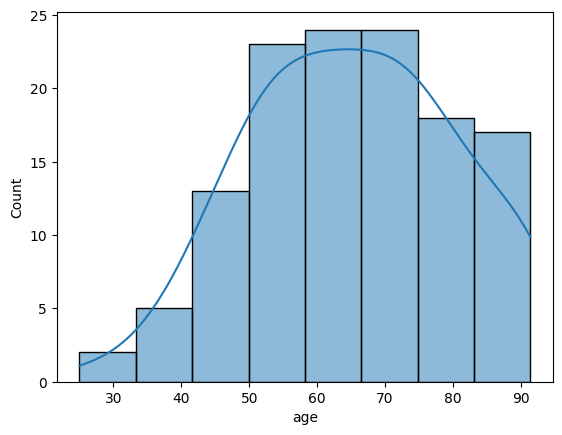

In [134]:
los_df['age'] = (los_df['ADMITTIME'].dt.year - los_df['DOB'].dt.year)
los_df['age'] = los_df['age'].mask(los_df['age'] > 89, 91.4)
import seaborn as sns

sns.histplot(los_df['age'], kde=True)

print(los_df.shape)
los_df.head()


In [135]:
df_24h_vitals = pd.merge(
    los_df[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME']],
    chart_events_df[['SUBJECT_ID', 'HADM_ID', 'CHARTTIME', 'ITEMID', 'VALUENUM']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)

df_24h_vitals.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,CHARTTIME,ITEMID,VALUENUM
0,249,116935,2149-12-17 20:41:00,2149-12-19 02:00:00,198.0,15.0
1,249,116935,2149-12-17 20:41:00,2149-12-19 02:00:00,211.0,103.0
2,249,116935,2149-12-17 20:41:00,2149-12-19 02:00:00,618.0,23.0
3,249,116935,2149-12-17 20:41:00,2149-12-19 02:00:00,646.0,99.0
4,249,116935,2149-12-17 20:41:00,2149-12-19 02:00:00,683.0,400.0


In [136]:
df_24h_vitals = df_24h_vitals[
    (df_24h_vitals['CHARTTIME'] >= df_24h_vitals['ADMITTIME']) & 
    (df_24h_vitals['CHARTTIME'] <= df_24h_vitals['ADMITTIME'] + pd.Timedelta(hours=24))
]
print(df_24h_vitals.shape)
print(df_24h_vitals.isnull().sum())
df_24h_vitals.head()

(7097, 6)
SUBJECT_ID     0
HADM_ID        0
ADMITTIME      0
CHARTTIME      0
ITEMID         0
VALUENUM      47
dtype: int64


,SUBJECT_ID,HADM_ID,ADMITTIME,CHARTTIME,ITEMID,VALUENUM
589,249,116935,2149-12-17 20:41:00,2149-12-18 20:10:00,762.0,NaN
590,249,116935,2149-12-17 20:41:00,2149-12-18 20:10:00,916.0,NaN
591,249,116935,2149-12-17 20:41:00,2149-12-18 20:10:00,920.0,NaN
592,249,116935,2149-12-17 20:41:00,2149-12-18 20:10:00,924.0,NaN
593,249,116935,2149-12-17 20:41:00,2149-12-18 20:10:00,927.0,NaN


In [137]:
vital_features = df_24h_vitals.pivot_table(
    index=['SUBJECT_ID', 'HADM_ID'],
    columns='ITEMID',
    values='VALUENUM',
    aggfunc=['mean', 'max', 'min']
)
vital_features.columns = [f'{agg}_{item}' for agg, item in vital_features.columns]  # Flatten column names
vital_features.reset_index(inplace=True)


In [138]:
# Pivot to create features (mean/max/min of each vital sign)
vital_features = df_24h_vitals.pivot_table(
    index=['SUBJECT_ID', 'HADM_ID'],
    columns='ITEMID',
    values='VALUENUM',
    aggfunc=['mean', 'max', 'min']
)
vital_features.columns = [f'{agg}_{item}' for agg, item in vital_features.columns]  # Flatten column names
vital_features.reset_index(inplace=True)

In [ ]:
def calculate_sofa(df, chartevents_df):
    """
    Calculate SOFA score using first 24h of ICU data.
    Args:
        df: DataFrame with SUBJECT_ID, HADM_ID, ADMITTIME
        chartevents_df: Raw CHARTEVENTS data
    Returns:
        DataFrame with SOFA components and total score
    """
    # Filter first 24h of chart events
    df_24h = pd.merge(
        df[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME']],
        chartevents_df,
        on=['SUBJECT_ID', 'HADM_ID'],
        how='left'
    )
    df_24h = df_24h[
        (df_24h['CHARTTIME'] >= df_24h['ADMITTIME']) & 
        (df_24h['CHARTTIME'] <= df_24h['ADMITTIME'] + pd.Timedelta(hours=24))
    ]
    
    # Aggregate worst values per admission
    agg_df = df_24h.groupby(['SUBJECT_ID', 'HADM_ID']).agg({
        'PaO2': 'min',          # Worst oxygenation
        'FiO2': 'max',          # Highest FiO2
        'Platelets': 'min',     # Worst thrombocytopenia
        'Bilirubin': 'max',     # Worst liver function
        'MAP': 'min',           # Worst hypotension
        'Creatinine': 'max',    # Worst renal function
        'GCS': 'min',           # Worst neurological status
        'Dopamine': 'max',      # Vasopressor use
        'Norepinephrine': 'max',
        'Epinephrine': 'max',
        'Dobutamine': 'max'
    }).reset_index()
    
    # SOFA Component Calculations
    ## 1. Respiratory (PaO2/FiO2 ratio)
    agg_df['PaO2_FiO2'] = agg_df['PaO2'] / (agg_df['FiO2'] + 1e-6)  # Avoid division by zero
    agg_df['SOFA_resp'] = np.select(
        [
            agg_df['PaO2_FiO2'] >= 400,
            (agg_df['PaO2_FiO2'] >= 300) & (agg_df['PaO2_FiO2'] < 400),
            (agg_df['PaO2_FiO2'] >= 200) & (agg_df['PaO2_FiO2'] < 300),
            (agg_df['PaO2_FiO2'] >= 100) & (agg_df['PaO2_FiO2'] < 200),
            agg_df['PaO2_FiO2'] < 100
        ],
        [0, 1, 2, 3, 4],
        default=0
    )
    
    ## 2. Coagulation (Platelets)
    agg_df['SOFA_coag'] = np.select(
        [
            agg_df['Platelets'] >= 150,
            (agg_df['Platelets'] >= 100) & (agg_df['Platelets'] < 150),
            (agg_df['Platelets'] >= 50) & (agg_df['Platelets'] < 100),
            (agg_df['Platelets'] >= 20) & (agg_df['Platelets'] < 50),
            agg_df['Platelets'] < 20
        ],
        [0, 1, 2, 3, 4],
        default=0
    )
    
    ## 3. Liver (Bilirubin)
    agg_df['SOFA_liver'] = np.select(
        [
            agg_df['Bilirubin'] < 1.2,
            (agg_df['Bilirubin'] >= 1.2) & (agg_df['Bilirubin'] < 2.0),
            (agg_df['Bilirubin'] >= 2.0) & (agg_df['Bilirubin'] < 6.0),
            (agg_df['Bilirubin'] >= 6.0) & (agg_df['Bilirubin'] < 12.0),
            agg_df['Bilirubin'] >= 12.0
        ],
        [0, 1, 2, 3, 4],
        default=0
    )
    
    ## 4. Cardiovascular (MAP + vasopressors)
    agg_df['SOFA_cv'] = np.select(
        [
            agg_df['MAP'] >= 70,
            (agg_df['MAP'] < 70) & (agg_df[['Dopamine', 'Norepinephrine', 'Epinephrine']].max(axis=1) == 0),
            (agg_df['Dopamine'] <= 5) | (agg_df['Dobutamine'] > 0),
            (agg_df['Dopamine'] > 5) | (agg_df['Norepinephrine'] <= 0.1),
            (agg_df['Dopamine'] > 15) | (agg_df['Norepinephrine'] > 0.1)
        ],
        [0, 1, 2, 3, 4],
        default=0
    )
    
    ## 5. CNS (GCS)
    agg_df['SOFA_cns'] = np.select(
        [
            agg_df['GCS'] == 15,
            (agg_df['GCS'] >= 13) & (agg_df['GCS'] <= 14),
            (agg_df['GCS'] >= 10) & (agg_df['GCS'] <= 12),
            (agg_df['GCS'] >= 6) & (agg_df['GCS'] <= 9),
            agg_df['GCS'] < 6
        ],
        [0, 1, 2, 3, 4],
        default=0
    )
    
    ## 6. Renal (Creatinine/Urine output)
    agg_df['SOFA_renal'] = np.select(
        [
            agg_df['Creatinine'] < 1.2,
            (agg_df['Creatinine'] >= 1.2) & (agg_df['Creatinine'] < 2.0),
            (agg_df['Creatinine'] >= 2.0) & (agg_df['Creatinine'] < 3.5),
            (agg_df['Creatinine'] >= 3.5) & (agg_df['Creatinine'] < 5.0),
            (agg_df['Creatinine'] >= 5.0)
        ],
        [0, 1, 2, 3, 4],
        default=0
    )
    
    # Total SOFA score
    agg_df['SOFA_24h'] = (
        agg_df['SOFA_resp'] + 
        agg_df['SOFA_coag'] + 
        agg_df['SOFA_liver'] + 
        agg_df['SOFA_cv'] + 
        agg_df['SOFA_cns'] + 
        agg_df['SOFA_renal']
    )
    
    return df.merge(
        agg_df[['SUBJECT_ID', 'HADM_ID', 'SOFA_24h'] + [c for c in agg_df.columns if c.startswith('SOFA_')]],
        on=['SUBJECT_ID', 'HADM_ID'],
        how='left'
    )

df_features = calculate_sofa(los_df, chart_events_df)

KeyError: "Column(s) ['Bilirubin', 'Creatinine', 'Dobutamine', 'Dopamine', 'Epinephrine', 'FiO2', 'GCS', 'MAP', 'Norepinephrine', 'PaO2', 'Platelets'] do not exist"